# Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [1]:
import os
import datetime as dt
from common.utils import TimeSeriesTensor, create_evaluation_df
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
np.set_printoptions(precision=2)

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Load the data from csv into a Pandas dataframe. Make sure to first complete the [0_data_setup](0_data_setup.ipynb) notebook.

In [2]:
file_name = os.path.join('data', 'energy.parquet')
energy = pd.read_parquet(file_name)
energy.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [3]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

T = 6
HORIZON = 3

Create training set containing only the model features

In [4]:
train = energy.copy()[:valid_start_dt]

Scale data. This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

In [5]:
from sklearn.preprocessing import StandardScaler

y_scaler = StandardScaler()
y_scaler.fit(train[['load']])

X_scaler = StandardScaler()
train[['load', 'temp']] = X_scaler.fit_transform(train)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [6]:
tensor_structure = {'X':(range(-T+1, 1), ['load', 'temp'])}
train_inputs = TimeSeriesTensor(train, 'load', HORIZON, tensor_structure)

In [7]:
train_inputs.dataframe.head()

tensor              target                 X                                \
feature                  y              load                                 
time step              t+1   t+2   t+3   t-5   t-4   t-3   t-2   t-1     t   
2012-01-01 05:00:00  -1.31 -1.03 -0.69 -1.07 -1.32 -1.52 -1.59 -1.59 -1.50   
2012-01-01 06:00:00  -1.03 -0.69 -0.36 -1.32 -1.52 -1.59 -1.59 -1.50 -1.31   
2012-01-01 07:00:00  -0.69 -0.36 -0.24 -1.52 -1.59 -1.59 -1.50 -1.31 -1.03   
2012-01-01 08:00:00  -0.36 -0.24 -0.23 -1.59 -1.59 -1.50 -1.31 -1.03 -0.69   
2012-01-01 09:00:00  -0.24 -0.23 -0.22 -1.59 -1.50 -1.31 -1.03 -0.69 -0.36   

tensor                                                   
feature              temp                                
time step             t-5   t-4   t-3   t-2   t-1     t  
2012-01-01 05:00:00 -0.81 -0.77 -0.91 -0.86 -0.81 -0.84  
2012-01-01 06:00:00 -0.77 -0.91 -0.86 -0.81 -0.84 -0.91  
2012-01-01 07:00:00 -0.91 -0.86 -0.81 -0.84 -0.91 -0.96  
2012-01-01 08:00:00 -0.86 -0.81 -0.84 -0.91 -0.96 -0.96  
2012-01-01 09:00:00 -0.81 -0.84 -0.91 -0.96 -0.96 -0.74

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [8]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[look_back_dt:test_start_dt][['load', 'temp']]
valid[['load', 'temp']] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, 'load', HORIZON, tensor_structure)

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

![Simple Encoder-Decoder](./images/simple_encoder_decoder.png)

In [9]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [10]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 10

In [11]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 2)))
model.add(RepeatVector(HORIZON))
model.add(GRU(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

model.compile(optimizer='RMSprop', loss='mse')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5)                 120       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 5)              0         
_________________________________________________________________
gru_2 (GRU)                  (None, 3, 5)              165       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 1)              6         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3)                 0         
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


In [12]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [13]:
history = model.fit(
    train_inputs['X'],
    train_inputs['target'],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valid_inputs['X'], 
                     valid_inputs['target']),
    callbacks=[earlystop],
    verbose=1)

Train on 23369 samples, validate on 1462 samples
Epoch 1/10
23369/23369 [==============================] - 4s 174us/step - loss: 0.4248 - val_loss: 0.1697
Epoch 2/10
23369/23369 [==============================] - 3s 137us/step - loss: 0.1307 - val_loss: 0.0983
Epoch 3/10
23369/23369 [==============================] - 3s 141us/step - loss: 0.1017 - val_loss: 0.0844
Epoch 4/10
23369/23369 [==============================] - 4s 153us/step - loss: 0.0937 - val_loss: 0.0775
Epoch 5/10
23369/23369 [==============================] - 4s 150us/step - loss: 0.0882 - val_loss: 0.0732
Epoch 6/10
23369/23369 [==============================] - 4s 155us/step - loss: 0.0832 - val_loss: 0.0693
Epoch 7/10
23369/23369 [==============================] - 4s 154us/step - loss: 0.0791 - val_loss: 0.0648
Epoch 8/10
23369/23369 [==============================] - 4s 159us/step - loss: 0.0759 - val_loss: 0.0646
Epoch 9/10
23369/23369 [==============================] - 4s 160us/step - loss: 0.0732 - val_loss: 0.06

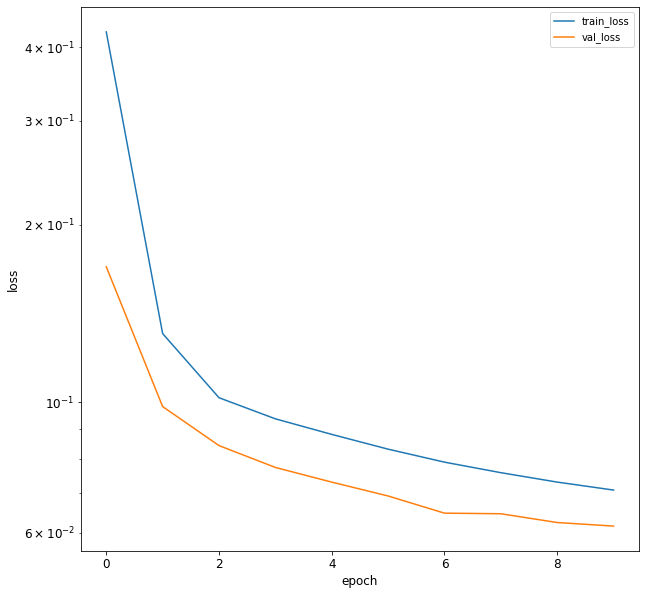

In [14]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

## Evaluate the model

In [15]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load', 'temp']]
test[['load', 'temp']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, 'load', HORIZON, tensor_structure)

In [16]:
predictions = model.predict(test_inputs['X'])

In [17]:
predictions

array([[-0.99, -0.3 ,  0.17],
       [-0.5 ,  0.09,  0.23],
       [-0.07,  0.23,  0.29],
       ...,
       [ 1.09,  0.66,  0.3 ],
       [ 0.72,  0.28, -0.05],
       [ 0.6 ,  0.35,  0.18]], dtype=float32)

Combine predictions with actual values, then unpivot for easier analysis. 

In [18]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,745.18","2,714.00"
1,2014-11-01 06:00:00,t+1,"3,025.00","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,266.59","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,354.95","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,476.51","3,436.00"


In [19]:
eval_df[eval_df.timestamp<=pd.to_datetime('2014-11-01 06:00:00')].sort_values('timestamp')

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,745.18","2,714.00"
1456,2014-11-01 05:00:00,t+2,"3,136.85","2,970.00"
2912,2014-11-01 05:00:00,t+3,"3,407.85","3,189.00"
1,2014-11-01 06:00:00,t+1,"3,025.00","2,970.00"
1457,2014-11-01 06:00:00,t+2,"3,362.98","3,189.00"
2913,2014-11-01 06:00:00,t+3,"3,439.71","3,356.00"


In [20]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1   0.01
t+2   0.03
t+3   0.05
Name: APE, dtype: float64

In [21]:
from common.utils import mape

print("MAPE: {:.2f}%".format(100* mape(eval_df['prediction'], eval_df['actual'])))

MAPE: 3.11%


Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

No handles with labels found to put in legend.


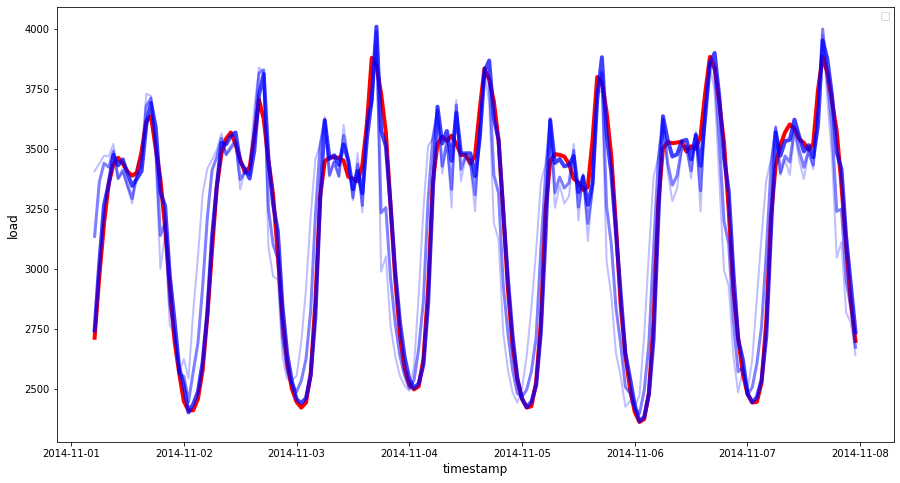

In [22]:
plot_df = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df[f't+{t}'] = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h==f't+{t}')]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()